In [7]:
import ssl
import urllib.request

ssl_context = ssl._create_unverified_context()

In [87]:
from dotenv import load_dotenv
import os
from pathlib import Path

from typing import Annotated, List, Optional, Literal,TypedDict

## For creating tools

from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.tools import tool
from langchain_core.language_models.chat_models import BaseChatModel


## For creating Agents
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages
from langgraph.prebuilt import create_react_agent






In [31]:
load_dotenv()
WORKING_DIRECTORY = Path.cwd()

## LLM Model Initilization

In [ ]:
#llm=ChatGroq(model="deepseek-r1-distill-llama-70b")
#print(llm.invoke("What is the capital of France?").content)

In [88]:
llm = ChatOpenAI(model="gpt-4o")

In [89]:
llm.invoke('Capital of Frace?')

AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 12, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BpZzUfwItn1dMXvedTsI2xZZBf0aU', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--294d06ad-c1da-4b91-aa10-e81493439c67-0', usage_metadata={'input_tokens': 12, 'output_tokens': 7, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## Tools Define

1. SEARCH TOOL USING TAVILY FOR PHARMA AND FINANCE
2. CREATE SUMMARY TOOL
3. CREATE DOCUMENT TOOL

In [90]:
# Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY,max_results=5)

In [91]:
@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

In [92]:
## Summary Tool
@tool
def create_summary(content: Annotated[str, "Research content to summarize"], file_name: Annotated[str, "File path to save the summary"],
) -> Annotated[str, "Path of the saved summary file"]:
    """Create and save a summary from research content."""
    # Ensure the file has a .txt extension for summaries
    if not file_name.endswith(('.txt', '.pdf','.doc')):
        file_name = file_name.rsplit(".", 1)[0] + ".txt" if "." in file_name else file_name + ".txt"
    
    file_path = WORKING_DIRECTORY / file_name
    with file_path.open("w", encoding='utf-8') as file:
        file.write(content)
    return f"Summary saved to {file_path}"

In [93]:
@tool
def create_document(
    content: Annotated[str, "Content to be written into the document"],
    file_name: Annotated[str, "File path to save the document"],
) -> Annotated[str, "Path of the saved document file"]:
    """Create and save a document from summary content as a Markdown file."""
    # Ensure the file has a .md extension for Markdown documents
    if not file_name.endswith(".md"):
        file_name = file_name.rsplit(".", 1)[0] + ".md" if "." in file_name else file_name + ".md"
    
    file_path = WORKING_DIRECTORY / file_name
    with file_path.open("w", encoding='utf-8') as file:
        file.write(content)
    return f"Document saved to {file_path}"

## Create Workflow

In [94]:
class State(MessagesState):
    next: str

In [95]:
def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

## Research Team

In [96]:
## Sample State will be 
state={"messages": ["What causes lung cancer?"]}

In [97]:
search_agent = create_react_agent(llm, tools=[search_tool])

def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])


def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


In [98]:
research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

In [99]:
# Build Research Team Graph
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

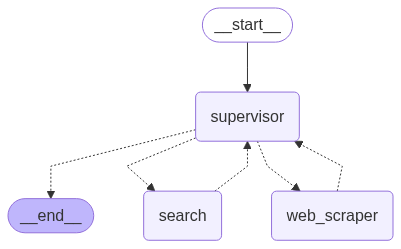

In [100]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

## Report Team

In [102]:
doc_writer_agent = create_react_agent(
    llm,
    tools=[create_document],
    prompt=(
        "You can write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)

def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

In [103]:
summary_agent = create_react_agent(
    llm,
    tools=[create_summary],
    prompt=(
        "You can read documents and create Summary for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def summary_node(state: State) -> Command[Literal["supervisor"]]:
    result = summary_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="summary")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

In [104]:
doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "summary"]
)

In [105]:
# Create the graph here
reporting = StateGraph(State)
reporting.add_node("supervisor", doc_writing_supervisor_node)
reporting.add_node("doc_writer", doc_writing_node)
reporting.add_node("summary", summary_node)


reporting.add_edge(START, "supervisor")
reporting_graph = reporting.compile()

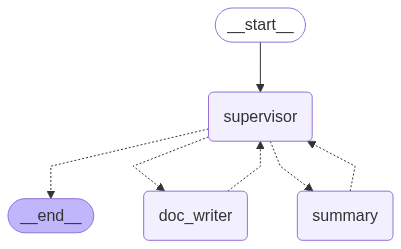

In [106]:
from IPython.display import Image, display

display(Image(reporting_graph.get_graph().draw_mermaid_png()))

## MAIN SUPERVISOR

In [107]:
def call_research_team(state: State) -> Command[Literal["main_supervisor"]]:
    """Call the research team and return results to main supervisor."""
    response = research_graph.invoke({"messages": state["messages"]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, 
                    name="research_team"
                )
            ]
        },
        goto="main_supervisor",
    )

In [109]:
def call_reporting_team(state: State) -> Command[Literal["main_supervisor"]]:
    """Call the Reporting team and return results to main supervisor."""
    response = reporting_graph.invoke({"messages": state["messages"]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, 
                    name="generator_team"
                )
            ]
        },
        goto="main_supervisor",
    )

In [110]:
main_supervisor_node = make_supervisor_node(llm, ["research_team", "generator_team"])

In [111]:
main_builder = StateGraph(State)
main_builder.add_node("main_supervisor", main_supervisor_node)
main_builder.add_node("research_team", call_research_team)
main_builder.add_node("generator_team", call_reporting_team)
main_builder.add_edge(START, "main_supervisor")
main_graph = main_builder.compile()

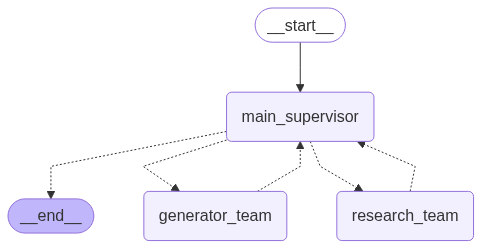

In [112]:
main_builder.compile()

In [116]:
for s in main_graph.stream(
    {
        "messages": [
            ("user", "Provide details about recent Investment happened in Tamil Nadu?")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'main_supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content="Recent investments in Tamil Nadu include several significant developments:\n\n1. **Saint-Gobain Investment**: Saint-Gobain announced a substantial investment in Tamil Nadu on October 6, 2023. This involves a series of green and brownfield investments in various manufacturing sectors, increasing their total investment in the state to over INR 8000 Crores. The CEO, Benoit Bazin, committed these investments as part of a meeting with the Chief Minister, with a focus on contributing to the state's vision of becoming a 'One Trillion Dollar Economy' and achieving carbon neutrality by 2050. [Source](https://in.saint-gobain-glass.com/press-releases/saint-gobain-announces-significant-investment-tamil-nadu)\n\n2. **Tamil Nadu Cabinet Approved Projects**: On October 31, 2023, the Tamil Nadu cabinet approved structured packages for eight investment projects totaling Rs 7,000 crore across various

In [114]:
agent_output =main_graph.invoke({"messages": [("user", "What is the GDP of tamil Nadu in 2025?")]}, subgraphs=True)

In [122]:
agent_output[1]['messages'][-1].content

'In 2025, the Gross State Domestic Product (GSDP) of Tamil Nadu is estimated to be approximately $419.74 billion (₹35.678 trillion).'